# Classification using GMM
Here we try a differnt approach to classification. For each artist in the dataset we model the mfcc coming from their songs as a guassian mixture model with a "big" number of components. So we train for each artist a GMM (using train songs) and estimate it's parameters (the weights, the means and the covariances) by expected maximization. Then for every frame of every song in the test set we compute the log-likelihood for that frame of coming from the model of each artist. We the assign the frame to the artist with the highest score and then the song according to the artist that has recieved the majority of "votes".

In [113]:
#load libraries
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.discriminant_analysis
import sklearn.mixture
import librosa.display
import numpy
import random
import pandas
import seaborn
import json
import operator

### Load Features
After the extraction of the features using the code provided in **Feature_Extraction.ipynb** we can simply load them from the .txt files (this will save time since feature extration can take a while).

In [115]:
with open('x.txt', 'r') as filehandle:
    y = json.load(filehandle)
with open('SR.txt', 'r') as filehandle:
    SR = json.load(filehandle)
with open('MFCC.txt', 'r') as filehandle:
    MFCC = json.load(filehandle)

In [116]:
##convert mfccs from list to numpy array that are faster to work with
x={}
for sr in SR:
    x[sr]={}
    for n_mfcc in MFCC:
        x[sr][n_mfcc]=[]
            
for sr in y:
    for n_mfcc in y[sr]:
        for t in y[sr][n_mfcc]:
            x[int(sr)][int(n_mfcc)].append({"artist": t["artist"],
                                            "song": t["song"],
                                            "mfcc":numpy.asarray(t["mfcc"])})

### Create a Balanced Train-Test split
Now we create a random, but balanced, train-test split, meaning that we control randomness in a way to use for training the model the same number of songs per artist (around 3/4 for train and 1/4 for test)

In [117]:
#create list of artists
artistlist=[]
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)


#count number of songs for each artist
songcount={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songcount:
        songcount[t["artist"]] = 1
    else:
        songcount[t["artist"]]+=1
#print(songcount)


#find number of songs for the artist having the smallest number of songs
artist_with_min = min(songcount.keys(), key=(lambda k: songcount[k]))
min_song=songcount[artist_with_min]


#number of song per artist to use as train
N=int(min_song*3/4)
#print(N)


#Create a list of songs per each artist
songs={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songs:
        songs[t["artist"]]=[]
    songs[t["artist"]].append(t["song"])
#print(songs)

###create split
split={}
for artist in artistlist:
    split[artist]={}
    split[artist]["train"],split[artist]["test"]=sklearn.model_selection.train_test_split(songs[artist]
                                                                                          ,train_size=N
                                                                                          ,random_state=1)
songtrain=[]
songtest=[]
for artist in artistlist:
    songtrain = songtrain + split[artist]["train"]
    songtest = songtest + split[artist]["test"]
                     

#print(songtrain)
#print(songtest)

In [118]:
##create dictionary such that to each artist correspond the list of its real songs
##this will be usefull to compare predictions with real values
song_and_artist_test={}
for t in x[2500][4]:
    if t["artist"] not in song_and_artist_test:
        song_and_artist_test[t["artist"]] = []
    if t["song"] in songtest:
        song_and_artist_test[t["artist"]].append(t["song"])

# Classification using GMM to model each artist:
Here we run the model letting vary the "quality" of features extracted.

In [120]:
#SR=[2500]    #to test
#MFCC=[4]     #to test


#initialize CM, this will store the confusion matrices of all models
CM={}
for sr in SR:
    CM[sr]={}
    for n_mfcc in MFCC:
        CM[sr][n_mfcc]=0

#loop over samplig rates and number of mfcc
for sr in SR:
    for n_mfcc in MFCC:
        #print((sr,n_mfcc))

        
        #train a GMM for each artist
        gmmdict={}
        for artist in artistlist:
            features_train=numpy.empty((1,n_mfcc))
            for t in x[sr][n_mfcc]:
                if t["artist"]==artist:
                    if t["song"] in songtrain:
                        features_train=numpy.vstack((features_train, t["mfcc"]))
            features_train=numpy.delete(features_train,0,0)
            gmm = sklearn.mixture.GaussianMixture(n_components=32, covariance_type='diag',max_iter=20,tol=0.01)
            gmm.fit(features_train)
            gmmdict[artist]=gmm    

            
        #create a matrix with test features and also ordered labels for song adn arstist
        features_test=numpy.empty((1,n_mfcc))
        artist_labels_test=[]
        song_labels_test=[]
        for t in x[sr][n_mfcc]:
            if t["song"] in songtest:
                features_test=numpy.vstack((features_test, t["mfcc"]))
                for _ in range(t["mfcc"].shape[0]):
                    artist_labels_test.append(t["artist"])
                    song_labels_test.append(t["song"])
        features_test=numpy.delete(features_test,0,0)
        
        #frame predictions
        artist_pred_gmm=[]
        for t in features_test:
            score={}
            for artist in artistlist:
                model = gmmdict[artist]
                score[artist]= model.score(numpy.reshape(t,(1,-1)))
            pred = max(score, key=lambda key: score[key])
            artist_pred_gmm.append(pred)
        
   
        #songs predictions
        out_gmm={}
        for song in songtest:
            v=[artist_pred_gmm[u] for u in range(len(artist_pred_gmm)) if song_labels_test[u] == song]
            out_gmm[song]=max(set(v), key=v.count)
        out_gmm
            
            
        ##create dictioary such that to each artist correspond the list of its predicted songs
        song_and_artist_pred_gmm={}
        for key,value in out_gmm.items():
            if value not in song_and_artist_pred_gmm:
                song_and_artist_pred_gmm[value] = []
            song_and_artist_pred_gmm[value].append(key)
            
        ##initialize confusion matrix   
        N_art=len(artistlist)
        conf_matrix_gmm = pandas.DataFrame(numpy.zeros(shape=(N_art,N_art)), columns = artistlist, index=artistlist)

        ##place in position (i,j) the number of songs from artist i predicted as of artist j
        for artist_t, listsong_t in song_and_artist_test.items():
            for artist_p, listsong_p in song_and_artist_pred_gmm.items():
                tot=len(set(listsong_t).intersection(listsong_p))
                conf_matrix_gmm[artist_p][artist_t]=tot
        #print(conf_matrix_gmm)

        #store confusion matrix
        CM[sr][n_mfcc]=conf_matrix_gmm

               Ligabue  Tiziano Ferro
Ligabue            5.0            2.0
Tiziano Ferro      0.0            8.0
               Ligabue  Tiziano Ferro
Ligabue            6.0            1.0
Tiziano Ferro      4.0            4.0
               Ligabue  Tiziano Ferro
Ligabue            6.0            1.0
Tiziano Ferro      3.0            5.0
               Ligabue  Tiziano Ferro
Ligabue            6.0            1.0
Tiziano Ferro      1.0            7.0
               Ligabue  Tiziano Ferro
Ligabue            6.0            1.0
Tiziano Ferro      1.0            7.0
               Ligabue  Tiziano Ferro
Ligabue            5.0            2.0
Tiziano Ferro      0.0            8.0
               Ligabue  Tiziano Ferro
Ligabue            6.0            1.0
Tiziano Ferro      0.0            8.0
               Ligabue  Tiziano Ferro
Ligabue            7.0            0.0
Tiziano Ferro      1.0            7.0
               Ligabue  Tiziano Ferro
Ligabue            7.0            0.0
Tiziano Ferr

# Performances Evaluation
Now we use all the confusion matrices stored in **CM** to evaluate performances. To this end we calculate class specific *precison* and *recall* and then we will average the values. This *macro*-averaged measures are suitable for assessing performaces of our models because every class has almost the same number of observations. For situations in which a significative differnce is present is better to use *micro*-averaged measures. Moreover we will also evaluate F1 score (that is a combination between *precison* and *recall* and is considered a good measure).

In [121]:
#inizialize PREC_REC
PREC_REC={}
for sr in SR:
    PREC_REC[sr]={}
    for n_mfcc in MFCC:
        PREC_REC[sr][n_mfcc]=0

#calculate precison and recall
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM[sr][n_mfcc])
        recall = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 1))
        precision = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 0))
        F1 = (2*precision*recall)/(precision+recall)
        PREC_REC[sr][n_mfcc]={"recall":round(recall,3),"precision":round(precision,3),"F1":round(F1,3)}

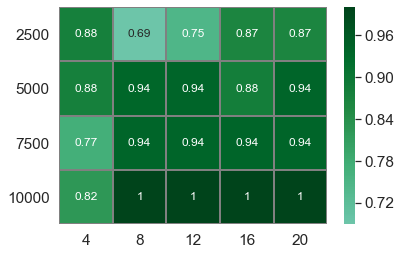

In [122]:
#visualization of F1 index
F1 = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        F1[n_mfcc][sr]=PREC_REC[sr][n_mfcc]["F1"]

#nice heatmap
seaborn.set(font_scale=1.4)
seaborn.heatmap(F1, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="BuGn",center=0.7)
plt.yticks(rotation=0, horizontalalignment='right')
plt.show()